## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [1]:
!wget https://thome.isir.upmc.fr/classes/RITAL/input.txt

--2023-03-18 18:00:24--  https://thome.isir.upmc.fr/classes/RITAL/input.txt
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  1.54MB/s    in 0.7s    

2023-03-18 18:00:26 (1.54 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
! pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.0 MB/s eta 0:00:00


In [3]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)

file_len = 1115394


In [4]:
print(file[0:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk` 
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [6]:
import time, math

#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor

#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)
    
    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. 
print(char_tensor("abcdefg"))  
print(random_chunk(20))  

(tensor([[14, 94, 23, 24, 29, 73, 94, 22, 18, 16],
        [27, 14, 28, 18, 13, 14, 28, 94, 29, 17],
        [94, 22, 34, 94, 25, 10, 27, 14, 23, 29],
        [68, 29, 18, 28, 94, 12, 24, 32, 10, 27]]), tensor([[94, 23, 24, 29, 73, 94, 22, 18, 16, 17],
        [14, 28, 18, 13, 14, 28, 94, 29, 17, 18],
        [22, 34, 94, 25, 10, 27, 14, 23, 29, 28],
        [29, 18, 28, 94, 12, 24, 32, 10, 27, 13]]))
tensor([[10, 11, 12, 13, 14, 15, 16]])
him this day in Padua


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [7]:
import torch.nn.functional as f

class RNN(nn.Module):
    
    def __init__(self, n_char, hidden_size, output_size, n_layers=1,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()
        
        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #Plusieurs essais effectués mais pas trouvé le bon
        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)  
        self.embed = nn.Embedding(n_char, hidden_size) 
        
        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)  
        self.rnn = nn.RNN(hidden_size, hidden_size )
        
        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)  
        self.predict = nn.Linear(hidden_size, output_size )
    
    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output
    
    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [8]:

def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)
            
    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [11]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad() 
    
    # predict output
    output = model(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer.step() 

    return loss.data.item() 



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 2s (100 0%) 2.5329]
Whacowings, cuthan'share thge se mant heat we ghindenghe ghant y, aisengen mesous, as, be a, ther t y  

 5s (200 1%) 2.4563]
Whote fay t psores, d in tthea hed toust hemy bere
SThan n gigatou liiltheald.
LII dillitheelisonand y 

 8s (300 1%) 2.4702]
Wherere t nsesereade'sed arthorne y mandoutotoucate are ho g,
We f we ter ta hereramyo avosoo m r whir 

 11s (400 2%) 2.4208]
Wheng'she ave h berd lll bulftowounothatond le, gout beeryieds cken mouthint d bil s:
ISy s o.
Mit hor 

 14s (500 2%) 2.4824]
Whe by sin he iste o bear.
Whetillo bsin sulteathas opre-

E: h wondery dofanofe t
NRI fitout.
And mee 

 17s (600 3%) 2.4228]
Whooatreay s anesheanowito be st at l anke fat ldas

Ang Y way be cothe ill ot wre I d m wa w

Noindu  

 19s (700 3%) 2.4395]
Wh in Inqulorit man:
BA ME:
D t s t A:
Wheveranak, ces ue wile k, fe RI Ointe w, the his it trit, wela 

 22s (800 4%) 2.4738]
Whicon ve dofoly in thand, y cint amere atr,
Wiser t tou wo mar ghis whepe wokesoupous,
RKEM

KeyboardInterrupt: ignored

## Visualize loss 

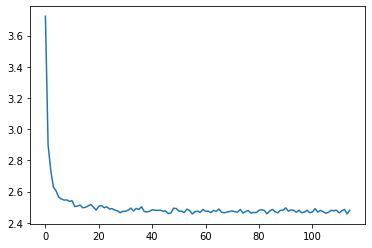

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [13]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

Touis, ndoulony fonde bon!
Dnesteven ulory pire s rd me hales;
ts cos
Burchesatrins t; at hyoere,
Thats'se
I awofo paswh acispppphand d S:
NThin tt bo, agofanderelle.
VINand o theld se; weye ye sson mt
----
Thay he as!






G g, y g hivand y aitssthalee theyoun t be yo otof and'd ororoul's, a has; bows:
Yanthy hos itom mosthatethanthelverent t d youl t?
F calinome and datherdoptht bl thiser.
DINGr d pe is
----
There the s,


The or t id ar soof me mut s has the no s her the h wathache bin han t he! this whoures it re thare ho he s, d thave y yo athin ghe tho is g arend wous the the s me menas mind w the the h
----
The he the he thand me the an the win he an s at ind the I me athe the the the the s theand the come t athis the the he he he the thyoron ath t this he me athe he the t the the ar t he ther our y thand 
----
The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the he the the the the the the the the th

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster
